## Importing the necessary libraries

In [31]:
import kagglehub
import shutil

from PIL import Image

import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

## Loading the dataset

In [3]:
# Download latest version
path = kagglehub.dataset_download("davidvazquezcic/yawn-dataset")

# Define the target path where you want to store the dataset in the content folder
colab_content_path = 'Dataset'

# Move the dataset to the content folder
shutil.move(path, colab_content_path)

print("Path to dataset files:", colab_content_path)

100%|██████████| 16.9M/16.9M [00:01<00:00, 8.91MB/s]

Extracting files...


Path to dataset files: Dataset


## Data Preprocessing

In [4]:
# Dataset path
dataset_path = 'Dataset'

# Image parameters
img_height, img_width = 128, 128
batch_size = 32

# Load images and labels
X, y = [], []

# Loop through classes (assuming folder names are 'yawn' and 'no_yawn')
for label, class_name in enumerate(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = image.load_img(img_path, target_size=(img_height, img_width))
            img_array = image.img_to_array(img) / 255.0  # Normalize pixel values
            X.append(img_array)
            y.append(label)

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# Split the data into training (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Now split the temp data equally into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Preprocessed Data Statistics

In [19]:
# Print the number of samples in each label (yawn vs no_yawn) for each dataset

def print_label_counts(y, set_name):
    label_counts = np.bincount(y)
    print(f"Label counts in {set_name}:")
    print(f"  No Yawn: {label_counts[0]}")
    print(f"  Yawn: {label_counts[1]}")
    print()

# Print counts for each set
print_label_counts(y_train, "Training Set")
print_label_counts(y_val, "Validation Set")
print_label_counts(y_test, "Test Set")

# Print the shapes of X and y variables
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of X_test: {X_test.shape}")

print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of y_test: {y_test.shape}")

Label counts in Training Set:
  No Yawn: 2045
  Yawn: 2050

Label counts in Validation Set:
  No Yawn: 282
  Yawn: 230

Label counts in Test Set:
  No Yawn: 264
  Yawn: 248

Shape of X_train: (4095, 128, 128, 3)
Shape of X_val: (512, 128, 128, 3)
Shape of X_test: (512, 128, 128, 3)
Shape of y_train: (4095,)
Shape of y_val: (512,)
Shape of y_test: (512,)


## Model Architecture

In [5]:
# Build the CNN model with dropout 0.2
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),  # Dropout updated to 0.2

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.2),  # Dropout updated to 0.2

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),  # Dropout updated to 0.2

    layers.Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,273 (368.25 KB)

 Trainable params: 93,825 (366.50 KB)

 Non-trainable params: 448 (1.75 KB)

## Training

In [10]:
# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.4,
                              patience=3,
                              verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr],
    batch_size=16
)

Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9631 - loss: 0.1130 - val_accuracy: 0.9258 - val_loss: 0.2049 - learning_rate: 2.4414e-07
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9634 - loss: 0.1084 - val_accuracy: 0.9219 - val_loss: 0.2068 - learning_rate: 2.4414e-07
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9572 - loss: 0.1205 - val_accuracy: 0.9238 - val_loss: 0.2056 - learning_rate: 2.4414e-07
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9647 - loss: 0.1091 - val_accuracy: 0.9277 - val_loss: 0.2018 - learning_rate: 2.4414e-07
Epoch 5/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9575 - loss: 0.1257 - val_accuracy: 0.9277 - val_loss: 0.1970 - learning_rate: 2.4414e-07
Epoch 6/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9625 - loss: 0.1115 - val_accuracy: 0.9258 - val_loss: 0.2038 - learning_rate: 2.4414e-07
Epoch 7/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 

## Model performance on test set

In [24]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9535 - loss: 0.1698 
Test Loss: 0.1643953025341034
Test Accuracy: 0.951171875


## Classification Report

In [14]:
# Predict probabilities and convert to binary class labels
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Threshold at 0.5

# Classification report
report = classification_report(y_test, y_pred, target_names=['No Yawn', 'Yawn'])

# Print the classification report
print(report)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

     No Yawn       0.92      1.00      0.95       264
        Yawn       1.00      0.90      0.95       248

    accuracy                           0.95       512
   macro avg       0.96      0.95      0.95       512
weighted avg       0.95      0.95      0.95       512



# Evaluation of misclassifications

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Number of misclassifications: 25


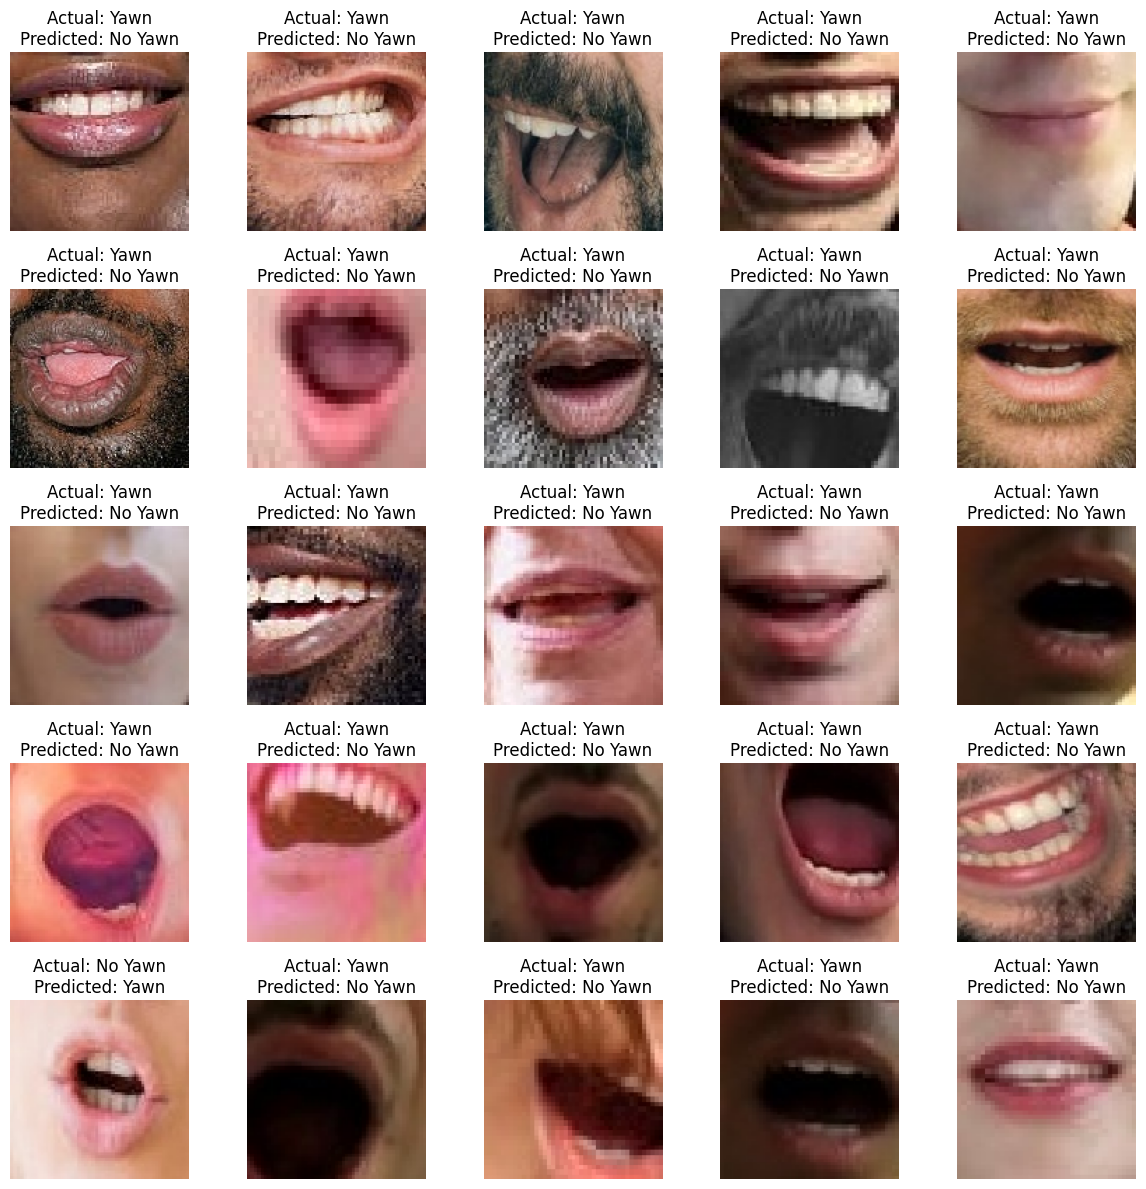

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


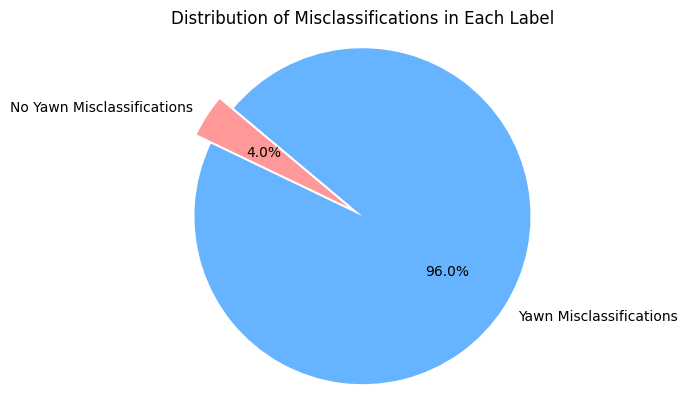

In [30]:
# Get model predictions for the test set (probabilities)
y_pred = model.predict(X_test)

# Convert probabilities to binary labels (0 or 1)
y_pred_binary = (y_pred > 0.5).astype("int32")

# Find the misclassified indices
misclassified_indices = np.where(y_pred_binary.flatten() != y_test)[0]

print(f"Number of misclassifications: {len(misclassified_indices)}")

# Plot the misclassified images with actual vs predicted labels
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 12))  # 5x5 grid for 25 images
axes = axes.flatten()

for i, index in enumerate(misclassified_indices[:25]):  # Display up to 25 misclassified images
    img = X_test[index]
    actual_label = y_test[index]
    predicted_label = y_pred_binary[index][0]

    # Convert numeric labels to strings for readability
    actual_label_str = "Yawn" if actual_label == 1 else "No Yawn"
    predicted_label_str = "Yawn" if predicted_label == 1 else "No Yawn"

    # Plot the image
    ax = axes[i]
    ax.imshow(img)
    ax.axis('off')

    # Display actual and predicted labels on the image
    ax.set_title(f"Actual: {actual_label_str}\nPredicted: {predicted_label_str}")

plt.tight_layout()
plt.show()

# Get model predictions for the test set (probabilities)
y_pred = model.predict(X_test)

# Convert probabilities to binary labels (0 or 1)
y_pred_binary = (y_pred > 0.5).astype("int32")

# Find the misclassified indices
misclassified_indices = np.where(y_pred_binary.flatten() != y_test)[0]

# Separate misclassifications by class (0: No Yawn, 1: Yawn)
misclassified_labels = y_test[misclassified_indices]  # Actual labels of misclassified samples

# Count the misclassifications for each label (0 and 1)
no_yawn_misclassifications = np.sum(misclassified_labels == 0)
yawn_misclassifications = np.sum(misclassified_labels == 1)

# Create a pie chart to show the distribution of misclassifications
labels = ['No Yawn Misclassifications', 'Yawn Misclassifications']
sizes = [no_yawn_misclassifications, yawn_misclassifications]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # "explode" the first slice (No Yawn)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.title('Distribution of Misclassifications in Each Label')
plt.show()

## Accuracy and loss curves

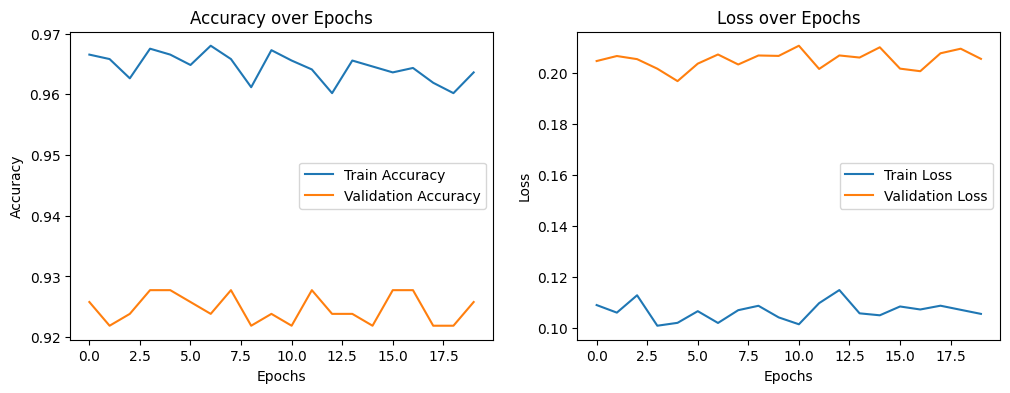

In [28]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()